In [1]:
import joblib
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score
)

params = {
    "objective":        "binary",
    "boosting_type":    "gbdt",
    "learning_rate":    0.05,
    "num_leaves":       31,
    "max_depth":        -1,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq":     5,
    "seed":             42,
    "verbose":          -1
}


In [2]:
X_mem = joblib.load("X_embeddings.pkl", mmap_mode="r")    
X32  = X_mem.astype(np.float32, copy=False)               
joblib.dump(X32, "X32_embeddings.pkl")
print("X32:", X32.shape, X32.dtype, f"≈{X32.nbytes/2**30:.2f} GiB")

X32: (214702, 2816) float32 ≈2.25 GiB


In [3]:
X = joblib.load("X32_embeddings.pkl", mmap_mode="r")  
y = joblib.load("y_labels.pkl")
y_bin = (y == 1).astype(int)
print("Data:", X.shape, "Labels:", y_bin.shape)

Data: (214702, 2816) Labels: (214702,)


In [4]:
idx = np.arange(len(y_bin))

idx_temp, idx_test = train_test_split(
    idx, test_size=0.20, stratify=y_bin, random_state=42
)
idx_train, idx_val = train_test_split(
    idx_temp, test_size=0.25, stratify=y_bin[idx_temp], random_state=42
)

print("Indices:", len(idx_train), "train;", len(idx_val), "val;", len(idx_test), "test")


Indices: 128820 train; 42941 val; 42941 test


In [5]:
full_ds = lgb.Dataset(
    X, label=y_bin,
    free_raw_data=False)

dtrain = full_ds.subset(idx_train)
dval   = full_ds.subset(idx_val)

In [ ]:
gbm = lgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    valid_sets=[dtrain, dval],
    valid_names=["train", "valid"],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

In [15]:
X_test = X[idx_test]
y_test = y_bin[idx_test]

y_train_pred = (gbm.predict(X[idx_train]) >= 0.5).astype(int)
y_train_proba= gbm.predict(X[idx_train])
y_test_pred  = (gbm.predict(X_test) >= 0.5).astype(int)
y_test_proba = gbm.predict(X_test)

def rpt(name, ys, yp, yp_proba):
    print(f"\n=== {name} ===")
    print(f"AUC: {roc_auc_score(ys, yp_proba):.4f}")
    print("Confusion:\n", confusion_matrix(ys, yp))
    print(classification_report(ys, yp, digits=4))

rpt("TRAIN", y_bin[idx_train], y_train_pred,  y_train_proba)
rpt("TEST",  y_test,               y_test_pred,   y_test_proba)



=== TRAIN ===
AUC: 0.9683
Confusion:
 [[55247  9226]
 [ 2933 61414]]
              precision    recall  f1-score   support

           0     0.9496    0.8569    0.9009     64473
           1     0.8694    0.9544    0.9099     64347

    accuracy                         0.9056    128820
   macro avg     0.9095    0.9057    0.9054    128820
weighted avg     0.9095    0.9056    0.9054    128820


=== TEST ===
AUC: 0.9692
Confusion:
 [[18435  3057]
 [  886 20563]]
              precision    recall  f1-score   support

           0     0.9541    0.8578    0.9034     21492
           1     0.8706    0.9587    0.9125     21449

    accuracy                         0.9082     42941
   macro avg     0.9124    0.9082    0.9080     42941
weighted avg     0.9124    0.9082    0.9079     42941



In [16]:
final_rounds = gbm.best_iteration
final_gbm = lgb.train(
    params,
    full_ds,
    num_boost_round=final_rounds
)
print(f"Final model trained for {final_rounds} rounds on full dataset.")


Final model trained for 1000 rounds on full dataset.


In [ ]:
final_gbm.save_model("lgbm_full.booster")

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.9075    0.8009    0.8509     21492
           1     0.8215    0.9182    0.8672     21449

    accuracy                         0.8595     42941
   macro avg     0.8645    0.8595    0.8590     42941
weighted avg     0.8645    0.8595    0.8590     42941

=== Confusion Matrix ===
[[17212  4280]
 [ 1754 19695]]


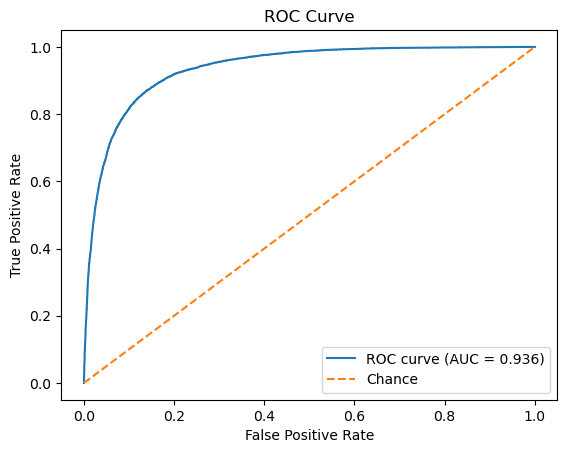

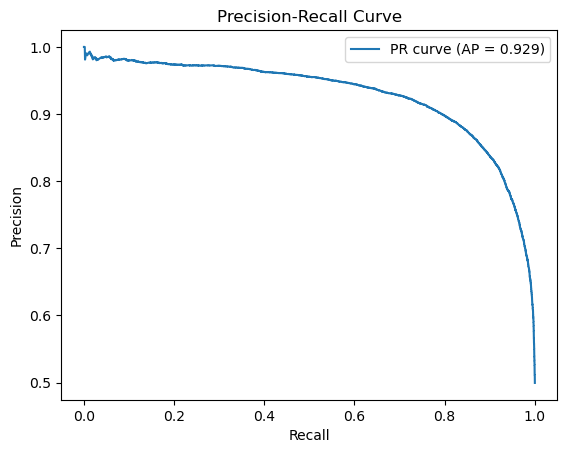

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

X_test = X[idx_test]
y_test = y_bin[idx_test]

y_proba = gbm.predict(X_test)                
y_pred  = (y_proba >= 0.5).astype(int)       

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)
plt.figure()
plt.plot(recall, precision, label=f"PR curve (AP = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision‑Recall Curve")
plt.legend()
plt.show()


In [13]:
import lightgbm as lgb
gbm = lgb.Booster(model_file="lgbm_full.booster")
# preds  = booster.predict(X_new)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

noise_levels = np.linspace(0, 0.2, 11)   # 0 % → 20 % noise
aucs = []

# compute per‐feature std once
feat_std = X_test.std(axis=0)

for σ in noise_levels:
    # add N(0, σ·σ_i) noise to each feature
    X_noisy = X_test + np.random.randn(*X_test.shape) * (feat_std * σ)
    y_proba = gbm.predict(X_noisy)
    aucs.append(roc_auc_score(y_test, y_proba))

# plot
plt.plot(noise_levels, aucs, marker='o')
plt.xlabel("Noise level (σ fraction of feature std)")
plt.ylabel("ROC AUC")
plt.title("Sensitivity to Input Noise")
plt.grid(True)
plt.show()
